# **TCC_p02_classificacao_SpaCy.ipynb**

# Etapa 1: Preparar os arquivos de treinamento

1. Importação de bibliotecas

* Pandas: para criação e manipulação de dataframes
* re: para utilização das expressões regulares em operações de transformações em string.
* numpy: para trabalhar com array.
* string: para importar sinais de pontuação.
* random: para misturar os dados de treinamento.
* nltk: usada para tokenizar textos em sentenças dos votos e dos resumos para a impressão do pdf com os resumos.
* nltk punkt: Punkt é uma ferramenta de segmentação de frases neutra em termos de linguagem utilizada na tokenização.
* nltk: para obter pacote para stemização.
* seaborn: biblioteca para visualização de dados baseada em Matplotlib para exibir a matriz de confusão do sklearn como mapa de calor.
* matplotlib: biblioteca para a criação de visualizações estáticas, animadas e interativas em Python. Utilizada para fazer alterações nas figuras: por exemplo, criar uma figura, criar uma área de plotagem em uma figura, plotar algumas linhas em uma área de plotagem e decorar a plotagem com rótulos.
* sklearn: para utilização das métricas de classificação matriz de confusão e acurácia.

2. Importação da biblioteca SpaCy e NLTK
*   A biblioteca ***SpaCy*** foi importada para o treinamento do modelo de classificação. 
*   Para a função preprocessamento, descrita no notebook *TCC_p01_preparar_X_treinamento_e_y_teste*, utiliza-se a ***SpaCy*** para tokenização do texto do voto e para lematização do texto do voto e a ***nltk*** para stemização. O preprocessamento, neste notebook, é utilizado para preparar o texto do voto do dataframe de teste. Também serão utilizadas para obtenção das stop_words (ambas). As stop_words da SpaCy serão concatenadas com as da nltk.

3.   Montar Drive
> Com ***drive.mount***('/content/drive', force_remount=True) os diretórios de dados do ***Google Drive*** são montados para utilização no ***Colab*** permitindo salvar arquivos e modelos treinados para utilização posterior, inclusive, em outros notebooks.


## 1. Importação de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

##2. Importação da biblioteca SpaCy e NLTK

In [ ]:
!pip install spacy==2.3.5

In [ ]:
import spacy
spacy.__version__

'2.3.5'

In [ ]:
!python -m spacy download pt
pln = spacy.load("pt")

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words_spacy = STOP_WORDS

In [ ]:
import string
import nltk
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('portuguese')
nltk.download('rslp')

In [ ]:
stop_words = set(stop_words_nltk + list(stop_words_spacy))

In [ ]:
pontuacoes = string.punctuation
pontuacoes

## 2. Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


# Etapa 2: Criação do classificador

1.   Ler arquivos do Drive gravados pelo notebook *TCC_p01_preparar_X_treinamento_e_y_teste*
*   Ler os dataframes X_treinamento_lema, X_treinamento_stemer e X_treinamento_original com os dados de treinamento preprocessados. De acordo com o tipo de treino, escolher o dataframe X_treinamento correspondente.
*   Ler o dataframe y_treinamento com a variável alvo. 

2.   Criar a base de treinamento para o SpaCy.
*   Para criar a base, concatenar o dataframe X_treinamento contendo a feature voto com o dataframe y_treinamento que contém a variável target (alvo) assunto.
*   No caso de X_treinamento, escolher o arquivo de acordo com o modelo a ser treinado, se com palavras originais, palavras lematizadas ou palavras stemizadas.
*   Transformar a variável alvo em um dicionário com as categorias existentes.

3.   Criar um modelo com as 4 categorias 'irpf', 'irpj', 'ngdt' e 'paf'

4.   Treinar o modelo definindo a quantidade de épocas e a quantidade de registros por batch

5.   Guardar o histórico de progressão dos erros

6.   Exibir gráfico com a progressão dos erros

7.   Gravar modelo treinado no Drive



## Treino com lematização

1. Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
url = '/content/drive/MyDrive/X_treinamento_lema.csv' 
X_treinamento_lema = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)
url = '/content/drive/MyDrive/y_treinamento_7124.csv' 
y_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

2.   Criar a base de treinamento para o SpaCy.

In [ ]:
#Preparar a base para o treinamento, concatenando o X com o y. 
df_treinamento = pd.concat([X_treinamento_lema, y_treinamento], axis=1, sort=False)
df_treinamento.head()

In [ ]:
base_dados_treinamento_final = []
for voto, assunto in zip(df_treinamento['voto'], df_treinamento['assunto']):
  if assunto == 'irpf':
    dic = ({'irpf': True, 'ngdt': False, 'irpj': False, 'paf': False}) 
  elif assunto == 'ngdt': 
    dic = ({'irpf': False, 'ngdt': True, 'irpj': False, 'paf': False})
  elif assunto == 'irpj': 
    dic = ({'irpf': False, 'ngdt': False, 'irpj': True, 'paf': False})
  elif assunto == 'paf': 
    dic = ({'irpf': False, 'ngdt': False, 'irpj': False, 'paf': True})
  base_dados_treinamento_final.append([voto, dic.copy()])

In [ ]:
base_dados_treinamento_final[:3]

3.   Criar um modelo com as 4 categorias 'irpf', 'irpj', 'ngdt' e 'paf'

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("irpf")
categorias.add_label("ngdt")
categorias.add_label("irpj")
categorias.add_label("paf")
modelo.add_pipe(categorias)
historico = []

4. Treinar o modelo definindo a quantidade de épocas e a quantidade de registros por batch

In [ ]:
#Rodou o treinamento em 9547s com 30 épocas passando de 512 em 512 registros, ou 14 batches por época. 
#Treinamento com lematização
modelo.begin_training()
for epoca in range(30):  #número de épocas. 30
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512): #número de registros passados. de quanto em quantos serão atualizados os pesos.
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0: #mostrar de 5 em 5 épocas.
    print(losses)

{'textcat': 3.8230729160204646e-05}
{'textcat': 5.282458772626342e-06}
{'textcat': 1.6528499102719252e-06}
{'textcat': 8.78107712765086e-07}
{'textcat': 6.063314117454865e-07}
{'textcat': 5.040392290212026e-07}


5.   Guardar o histórico de progressão dos erros

In [ ]:
#Obtém histórico da progressão dos erros para gerar gráfico
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))
historico_loss = np.array(historico_loss)

6.   Exibir gráfico com a progressão dos erros

Text(0, 0.5, 'Erro')

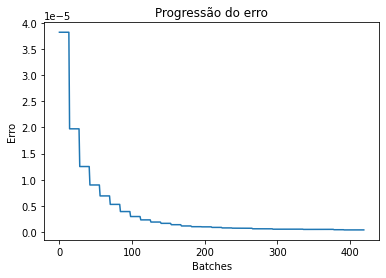

In [ ]:
#Exibe gráfico de linhas com a progressão do erro durante o treinamento
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

7.   Gravar modelo treinado no Drive

In [ ]:
#Salva modelo treinado no drive
modelo.to_disk("/content/drive/MyDrive/mod_TCC_spacy_lema")

##Treino com stemização

1. Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
url = '/content/drive/MyDrive/X_treinamento_stemer.csv' 
X_treinamento_stemer = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)
url = '/content/drive/MyDrive/y_treinamento_7124.csv' 
y_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

2.   Criar a base de treinamento para o SpaCy.

In [ ]:
#Preparar a base para o treinamento, concatenando o X com o y.
df_treinamento = pd.concat([X_treinamento_stemer, y_treinamento], axis=1, sort=False)
df_treinamento.head()

,voto,assunto
0,recurs tempes cumpr requisit legal admissibil ...,irpj
1,registr oportun cas vei julg recurs voluntári ...,ngdt
2,recurs voluntári apresent atend pressupost adm...,paf
3,julg process seg sistemá recurs repeti regulam...,irpj
4,julg process seg sistemá recurs repeti regulam...,irpj


In [ ]:
base_dados_treinamento_final = []
for voto, assunto in zip(df_treinamento['voto'], df_treinamento['assunto']):
  if assunto == 'irpf':
    dic = ({'irpf': True, 'ngdt': False, 'irpj': False, 'paf': False}) 
  elif assunto == 'ngdt': 
    dic = ({'irpf': False, 'ngdt': True, 'irpj': False, 'paf': False})
  elif assunto == 'irpj': 
    dic = ({'irpf': False, 'ngdt': False, 'irpj': True, 'paf': False})
  elif assunto == 'paf': 
    dic = ({'irpf': False, 'ngdt': False, 'irpj': False, 'paf': True})
  base_dados_treinamento_final.append([voto, dic.copy()])

In [ ]:
base_dados_treinamento_final[:3]

[['recurs tempes cumpr requisit legal admissibil ra tom conhec pass apreci recurs tempes cumpr requisit legal admissibil ra tom conhec pass apreci recorr apresent dcomp ra pag irpj códig darf compens homolog caracterís darf discrimin per dcomp acim identific local pag tend recolh sid integr utiliz quit débit contribuint rest crédit dispon compens débit inform per dcomp recorr decl recolh títul irpj darf pag recorr verific dev recolh promov retific dctf dia peç defês process recorr destac efetu retific dctf esclarec equívoc dctf orig motiv homolog declar compens retific declar ocorr dat posteri emiss despach decisóri julg inst administr drj conhec direit creditóri recorr dev aus prov conform trech abaix send consider dctf retific entreg transmiss per dcomp traz aut quaisqu element comprobatóri crédit pleite concluis repar feit despach decisóri anális direit creditóri reconhec compens pretend recorr grau recurs voluntári acost document process defend sufici comprov exist crédit junt escr

3.   Criar um modelo com as 4 categorias 'irpf', 'irpj', 'ngdt' e 'paf'

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("irpf")
categorias.add_label("ngdt")
categorias.add_label("irpj")
categorias.add_label("paf")
modelo.add_pipe(categorias)
historico = []

4. Treinar o modelo definindo a quantidade de épocas e a quantidade de registros por batch

In [ ]:
#Rodou o treinamento em 9279s com 30 épocas passando de 512 em 512 registros, ou 14 batches por época.  
#Treinamento com stemização
modelo.begin_training()
for epoca in range(30):  #número de épocas. 30
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512): #número de registros passados. de quanto em quantos serão atualizados os pesos.
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0: #mostrar de 5 em 5 épocas.
    print(losses)

{'textcat': 4.677392530538782e-05}
{'textcat': 4.3384017089920235e-06}
{'textcat': 1.3050260108116163e-06}
{'textcat': 7.340579983861062e-07}
{'textcat': 4.5605212406485407e-07}
{'textcat': 3.666806558388913e-07}


5.   Guardar o histórico de progressão dos erros

In [ ]:
#Obtém histórico da progressão dos erros para gerar gráfico
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))
historico_loss = np.array(historico_loss)  

6.   Exibir gráfico com a progressão dos erros

Text(0, 0.5, 'Erro')

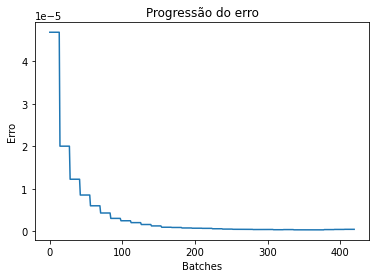

In [ ]:
#Exibe gráfico de linhas com a progressão do erro durante o treinamento
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

7.   Gravar modelo treinado no Drive

In [ ]:
#Salva modelo treinado no drive
modelo.to_disk("/content/drive/MyDrive/mod_TCC_spacy_stemer")

##Treino com palavras originais

1. Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
url = '/content/drive/MyDrive/X_treinamento_original.csv' 
X_treinamento_original = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)
url = '/content/drive/MyDrive/y_treinamento_7124.csv' 
y_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

2.   Criar a base de treinamento para o SpaCy.

In [ ]:
#Preparar a base para o treinamento, concatenando o X com o y. 
df_treinamento = pd.concat([X_treinamento_original, y_treinamento], axis=1, sort=False)
df_treinamento.head()

,voto,assunto
0,recurso tempestivo cumpre requisitos legais ad...,irpj
1,registrada oportunidade caso veio julgamento r...,ngdt
2,recurso voluntário apresentado atende pressupo...,paf
3,julgamento processo segue sistemática recursos...,irpj
4,julgamento processo segue sistemática recursos...,irpj


In [ ]:
base_dados_treinamento_final = []
for voto, assunto in zip(df_treinamento['voto'], df_treinamento['assunto']):
  if assunto == 'irpf':
    dic = ({'irpf': True, 'ngdt': False, 'irpj': False, 'paf': False}) 
  elif assunto == 'ngdt': 
    dic = ({'irpf': False, 'ngdt': True, 'irpj': False, 'paf': False})
  elif assunto == 'irpj': 
    dic = ({'irpf': False, 'ngdt': False, 'irpj': True, 'paf': False})
  elif assunto == 'paf': 
    dic = ({'irpf': False, 'ngdt': False, 'irpj': False, 'paf': True})
  base_dados_treinamento_final.append([voto, dic.copy()])

In [ ]:
base_dados_treinamento_final[:3]

[['recurso tempestivo cumpre requisitos legais admissibilidade razão tomo conhecimento passo apreciar recurso tempestivo cumpre requisitos legais admissibilidade razão tomo conhecimento passo apreciar recorrente apresentou dcomp razão pagamento irpj código darf compensação homologada características darf discriminado per dcomp acima identificado localizados pagamentos tendo recolhido sido integralmente utilizados quitação débitos contribuinte restando crédito disponível compensação débitos informados per dcomp recorrente declara recolheu título irpj darf pago recorrente verificou deveria recolhido promoveu retificação dctf dia peças defesa processo recorrente destaca efetuado retificação dctf esclarece equívoco dctf original motivou homologação declaração compensação retificação declaração ocorreu data posterior emissão despacho decisório julgamento instância administrativa drj conheceu direito creditório recorrente devido ausência provas conforme trecho abaixo sendo considerando dctf 

3.   Criar um modelo com as 4 categorias 'irpf', 'irpj', 'ngdt' e 'paf'

In [ ]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("irpf")
categorias.add_label("ngdt")
categorias.add_label("irpj")
categorias.add_label("paf")
modelo.add_pipe(categorias)
historico = []

4. Treinar o modelo definindo a quantidade de épocas e a quantidade de registros por batch

In [ ]:
#Rodou o treinamento em 10548s com 30 épocas passando de 512 em 512 registros, ou 14 batches por época. 
#Treinamento mantendo as palavras originais
modelo.begin_training()
for epoca in range(30):  #número de épocas. 30
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512): #número de registros passados. de quanto em quantos serão atualizados os pesos.
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0: #mostrar de 5 em 5 épocas.
    print(losses)

{'textcat': 4.736840742225468e-05}
{'textcat': 5.0551574020119006e-06}
{'textcat': 1.7112581609524113e-06}
{'textcat': 7.767493848120921e-07}
{'textcat': 5.685812745070962e-07}
{'textcat': 4.642640130114728e-07}


5.   Guardar o histórico de progressão dos erros

In [ ]:
#Obtém histórico da progressão dos erros para gerar gráfico
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))
historico_loss = np.array(historico_loss)

6.   Exibir gráfico com a progressão dos erros

Text(0, 0.5, 'Erro')

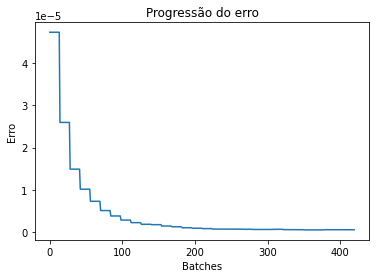

In [ ]:
#Exibe gráfico de linhas com a progressão do erro durante o treinamento
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [ ]:
#Salva modelo treinado no drive
modelo.to_disk("/content/drive/MyDrive/mod_TCC_spacy_original")

# Etapa 3: Avaliação na base de teste

0.   Função preprocessamento. 
*   A descrição desta função encontra-se no notebook *TCC_p01_preparar_X_treinamento_e_y_teste*. É a mesma função. Pensei em deixá-la em uma biblioteca minha no drive para importá-la como no exemplo abaixo, mas tive problemas com referências e optei por simplesmente replicá-la em todos os notebooks nos quais irei utilizá-la.
>
```
import sys
sys.path.append('/content/drive/MyDrive')
import libSandro
libSandro.preprocessamento()
```

1.   Carregar modelo treinado
2.   Carregar dataframes de teste, X_teste e y_teste, salvos no Drive
3.   Fazer o preprocessamento escolhendo lematização, stemização ou mantendo as palavras originais.
4.   Criar df concatenando X_teste['voto'] após preprocessamento com y_teste['assunto']
5.   Executar o modelo treinando para fazer as previsões
6.   Selecionar a previsão final pela categoria de maior probabilidade
*    Criar array indicando a categoria (literal irpf, irpj, ngdt ou paf). As previsões são retornas como um lista contendo dicionários com a probabilidade do voto ser uma das 4 categorias.
*   Exemplo do resultado em probabilidade:
>
```
[{'irpf': 0.0437471978366375,
  'irpj': 0.04022695869207382,
  'ngdt': 0.008066747337579727,
  'paf': 0.8190984129905701},...
```

7.   Obter as respostas reais da variável alvo
8.   Apurar a acurácia
9.   Mostrar o mapa de calor da matriz de confusão



0.   Função preprocessamento. 

In [ ]:
def preprocessamento(texto, tipo):
  """
  Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, 
  hífens iniciais, r$, espaços duplos e símbolos.  
  O objetivo é deixar apenas palavras que serão a base para as classificações.

  :parâmetro texto: recebe o texto integral de um voto.
  :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
  :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados.  

  """

  texto = texto.lower()
  texto = re.sub('([¹²³£¢¬§ªº°]{1})', ' ', texto) #excluir o símbolos listados
  texto = re.sub('([!"#%&\'\(\)\*\+,\./:;<=>\?@\[\]\^_`\{\|\}~]{1})', ' ', texto) #excluir as pontuações, exceto o hífen
  texto = re.sub('([0-9]*)[\.]*([0-9]+,[0-9]+)', ' ', texto)  #excluir valores com decimais após vírgulas 10.000,00 30,00
  texto = re.sub('([0-9]+)[.]+([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 9.420/99
  texto = re.sub('([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 70/99
  texto = re.sub('([0-9]+)', ' ', texto) #excluir números
  texto = re.sub('( [a-z]{1} )', ' ', texto) #excluir letras soltas
  texto = re.sub('( [a-z]{2} )', ' ', texto) #excluir palavras com 2 letras
  texto = re.sub(' -([a-z]*)', r'\1', texto) #excluir hífens iniciais
  texto = texto.replace('r$', ' ') #excluir r$
  texto = re.sub('( [ ]*)', ' ', texto) #excluir espaços duplos

  documento = pln(texto)
  lista = [token.text for token in documento if token.text not in stop_words and token.text not in string.punctuation]
  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  documento = pln(str_lista)
  
  lista = []
  if tipo == 'lema': # Lematização
    for token in documento:
      lista.append(token.lemma_)  
  elif tipo == 'stemer':
    for token in documento:
      stemmer = nltk.stem.RSLPStemmer()
      lista.append(stemmer.stem(token.text))
  else: #'original' ou qualquer outro valor
    for token in documento:
      lista.append(token.text)    

  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return str_lista

#Teste com stemização

1.   Carregar modelo treinado

In [ ]:
modelo_carregado = spacy.load('/content/drive/MyDrive/mod_TCC_spacy_stemer')
modelo_carregado

2.   Carregar dataframes de teste, X_teste e y_teste, salvos no Drive

In [ ]:
#Recuperando os arquivos de teste salvos no drive. 
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

3.   Fazer o preprocessamento escolhendo lematização, stemização ou mantendo as palavras originais.

In [ ]:
#rodar preprocessamento selecionando lematização (lema), stemização (stemer) ou original (original). 
X_teste['voto'] = X_teste['voto'].apply(preprocessamento, args=('stemer',))

4.   Criar df concatenando X_teste['voto'] após preprocessamento com y_teste['assunto']

In [ ]:
df = pd.concat([X_teste, y_teste], axis=1, sort=False)
df.head()

,voto,assunto
0,acord despach admissibil embarg declar recurs ...,paf
1,fat ensej autu objet pres aut relat acórd reco...,irpj
2,recurs tempes atend requisit admissibil tom co...,irpf
3,recurs voluntári apresent recorr atend requisi...,irpj
4,pres pressupost admissibil tempes conheç recur...,irpf


5.   Executar o modelo treinando para fazer as previsões

In [ ]:
previsoes = []
for voto in df['voto']:
 # print(voto)
  previsao = modelo_carregado(voto)
  previsoes.append(previsao.cats)

6.   Selecionar a previsão final pela categoria de maior probabilidade

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['irpf'] > previsao['irpj'] and previsao['irpf'] > previsao['ngdt'] and previsao['irpf'] > previsao['paf']:
    previsoes_final.append('irpf')
  elif previsao['irpj'] > previsao['irpf'] and previsao['irpj'] > previsao['ngdt'] and previsao['irpj'] > previsao['paf']:
    previsoes_final.append('irpj')
  elif previsao['ngdt'] > previsao['irpf'] and previsao['ngdt'] > previsao['irpj'] and previsao['ngdt'] > previsao['paf']:
    previsoes_final.append('ngdt')
  elif previsao['paf'] > previsao['irpf'] and previsao['paf'] > previsao['ngdt'] and previsao['paf'] > previsao['irpj']:
    previsoes_final.append('paf')    
previsoes_final = np.array(previsoes_final)

7.   Obter as respostas reais da variável alvo

In [ ]:
respostas_reais = df['assunto'].values
respostas_reais[0:10]

array(['paf', 'irpj', 'irpf', 'irpj', 'irpf', 'irpj', 'irpf', 'paf',
       'ngdt', 'irpf'], dtype=object)

8.   Apurar a acurácia

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.8500842223469961

9.   Mostrar o mapa de calor da matriz de confusão

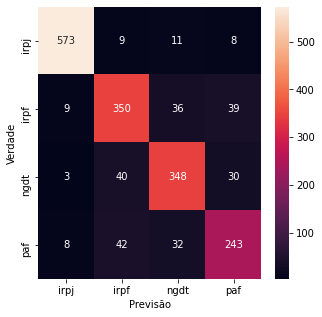

In [ ]:
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']
conf_mat_nb = confusion_matrix(respostas_reais, previsoes_final)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

#Teste com lema

1.   Carregar modelo treinado

In [ ]:
modelo_carregado = spacy.load('/content/drive/MyDrive/mod_TCC_spacy_lema')
modelo_carregado

2.   Carregar dataframes de teste, X_teste e y_teste, salvos no Drive

In [ ]:
#Recuperando os arquivos de teste salvos no drive. 
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

3.   Fazer o preprocessamento escolhendo lematização, stemização ou mantendo as palavras originais.

In [ ]:
#rodar preprocessamento selecionando lematização (lema), stemização (stemer) ou original (original). 
X_teste['voto'] = X_teste['voto'].apply(preprocessamento, args=('lema',))

4.   Criar df concatenando X_teste['voto'] após preprocessamento com y_teste['assunto']

In [ ]:
df = pd.concat([X_teste, y_teste], axis=1, sort=False)
df.head()

,voto,assunto
0,acordar despachar admissibilidade embargo decl...,paf
1,fato ensejar autuação objeto presente auto rel...,irpj
2,recurso tempestivo ater requisito admissibilid...,irpf
3,recurso voluntário apresentar recorrente ater ...,irpj
4,presentar pressupor admissibilidade tempestivo...,irpf


5.   Executar o modelo treinando para fazer as previsões

In [ ]:
previsoes = []
for voto in df['voto']:
 # print(voto)
  previsao = modelo_carregado(voto)
  previsoes.append(previsao.cats)

6.   Selecionar a previsão final pela categoria de maior probabilidade

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['irpf'] > previsao['irpj'] and previsao['irpf'] > previsao['ngdt'] and previsao['irpf'] > previsao['paf']:
    previsoes_final.append('irpf')
  elif previsao['irpj'] > previsao['irpf'] and previsao['irpj'] > previsao['ngdt'] and previsao['irpj'] > previsao['paf']:
    previsoes_final.append('irpj')
  elif previsao['ngdt'] > previsao['irpf'] and previsao['ngdt'] > previsao['irpj'] and previsao['ngdt'] > previsao['paf']:
    previsoes_final.append('ngdt')
  elif previsao['paf'] > previsao['irpf'] and previsao['paf'] > previsao['ngdt'] and previsao['paf'] > previsao['irpj']:
    previsoes_final.append('paf')    
previsoes_final = np.array(previsoes_final)

7.   Obter as respostas reais da variável alvo

In [ ]:
respostas_reais = df['assunto'].values
respostas_reais[0:10]

array(['paf', 'irpj', 'irpf', 'irpj', 'irpf', 'irpj', 'irpf', 'paf',
       'ngdt', 'irpf'], dtype=object)

8.   Apurar a acurácia

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.8517686692869174

9.   Mostrar o mapa de calor da matriz de confusão

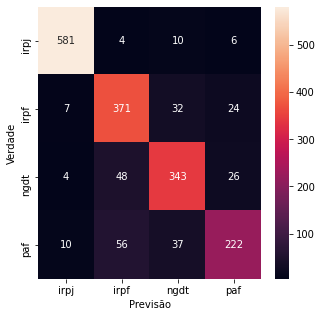

In [ ]:
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']
conf_mat_nb = confusion_matrix(respostas_reais, previsoes_final)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

#Teste com palavras originais

1.   Carregar modelo treinado

In [ ]:
modelo_carregado = spacy.load('/content/drive/MyDrive/mod_TCC_spacy_original')
modelo_carregado

2.   Carregar dataframes de teste, X_teste e y_teste, salvos no Drive

In [ ]:
#Recuperando os arquivos de teste salvos no drive. 
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

3.   Fazer o preprocessamento escolhendo lematização, stemização ou mantendo as palavras originais.

In [ ]:
#rodar preprocessamento selecionando lematização (lema), stemização (stemer) ou original (original). 
X_teste['voto'] = X_teste['voto'].apply(preprocessamento, args=('original',))

4.   Criar df concatenando X_teste['voto'] após preprocessamento com y_teste['assunto']

In [ ]:
df = pd.concat([X_teste, y_teste], axis=1, sort=False)
df.head()

,voto,assunto
0,acordo despacho admissibilidade embargos decla...,paf
1,fatos ensejaram autuação objeto presentes auto...,irpj
2,recurso tempestivo atende requisitos admissibi...,irpf
3,recurso voluntário apresentado recorrente aten...,irpj
4,presente pressuposto admissibilidade tempestiv...,irpf


5.   Executar o modelo treinando para fazer as previsões

In [ ]:
previsoes = []
for voto in df['voto']:
 # print(voto)
  previsao = modelo_carregado(voto)
  previsoes.append(previsao.cats)

6.   Selecionar a previsão final pela categoria de maior probabilidade

In [ ]:
previsoes_final = []
for previsao in previsoes:
  if previsao['irpf'] > previsao['irpj'] and previsao['irpf'] > previsao['ngdt'] and previsao['irpf'] > previsao['paf']:
    previsoes_final.append('irpf')
  elif previsao['irpj'] > previsao['irpf'] and previsao['irpj'] > previsao['ngdt'] and previsao['irpj'] > previsao['paf']:
    previsoes_final.append('irpj')
  elif previsao['ngdt'] > previsao['irpf'] and previsao['ngdt'] > previsao['irpj'] and previsao['ngdt'] > previsao['paf']:
    previsoes_final.append('ngdt')
  elif previsao['paf'] > previsao['irpf'] and previsao['paf'] > previsao['ngdt'] and previsao['paf'] > previsao['irpj']:
    previsoes_final.append('paf')    
previsoes_final = np.array(previsoes_final)

In [ ]:
previsoes_final[0:10]

array(['paf', 'irpj', 'irpf', 'irpj', 'irpf', 'irpj', 'irpf', 'paf',
       'irpj', 'irpf'], dtype='<U4')

7.   Obter as respostas reais da variável alvo

In [ ]:
respostas_reais = df['assunto'].values
respostas_reais[0:10]

array(['paf', 'irpj', 'irpf', 'irpj', 'irpf', 'irpj', 'irpf', 'paf',
       'ngdt', 'irpf'], dtype=object)

8.   Apurar a acurácia

In [ ]:
accuracy_score(respostas_reais, previsoes_final)

0.8315553060078608

9.   Mostrar o mapa de calor da matriz de confusão

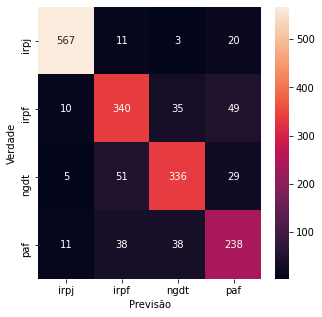

In [ ]:
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']
conf_mat_nb = confusion_matrix(respostas_reais, previsoes_final)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()